In [1]:
import cv2
import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity
from skimage.util import img_as_ubyte, img_as_float
from skimage.color import *

# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from line import Lane

In [2]:
def calibrate_camera():
    nx = 9
    ny = 6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Get image shape
    img_shape = plt.imread('camera_cal/calibration1.jpg').shape[0:2]
    img_shape = {'x': img_shape[1], 'y': img_shape[0]}
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
    
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_shape['x'], img_shape['y']), None, None)
    return ret, mtx, dist, rvecs, tvecs

In [3]:
def convert_to_grayscale(img, in_type = ''):
    assert in_type in ['HSV', 'HLS', 'RGB', 'BGR']
    if in_type == 'HSV':
        img_gray = cv2.cvtColor(img, cv2.COLOR_HSV2GRAY)
    elif in_type == 'HLS':
        img_gray = cv2.cvtColor(img, cv2.COLOR_HLS2GRAY)
    elif in_type == 'RGB':
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif in_type == 'BGR':
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def get_RGB_channels(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    return R,G,B

def get_HLS_channels(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = img[:,:,0]
    L = img[:,:,1]
    S = img[:,:,2]
    
    return H, L, S

def get_HSV_channels(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = img[:,:,0]
    S = img[:,:,1]
    V = img[:,:,2]
    
    return H, S, V

In [4]:
def sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    # Ensure img is grayscale
    assert orient in ['x','y']
    if len(img.shape) == 3:
        assert img.shape[2] == 1
    
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sobel_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Calculate directional gradient
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    if len(img.shape) == 3:
        assert img.shape[2] == 1
        
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    gradient_mag = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(gradient_mag)/255
    gradient_mag = (gradient_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(gradient_mag)
    mag_binary[(gradient_mag > thresh_min) & (gradient_mag < thresh_max)] = 1
    
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(-np.pi/2, np.pi/2)):
    # Calculate gradient direction
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    
    if len(img.shape) == 3:
        assert img.shape[2] == 1
    
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir > thresh_min) & (grad_dir < thresh_max)] = 1
    
    return dir_binary

In [5]:
def set_mask(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    
    vertices = np.array([[(150,700), (300,450), (980,450), (1130,700)]])
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
def get_binary(img, thresh = (0,255)):
    
    binary = np.zeros_like(img)
    
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    
    return binary

def return_final_binary():
    
    return final_binary

In [7]:
def get_perspective_transform():
    #straight_lines = plt.imread('test_images/straight_lines2.jpg')
    #straight_lines = convert_to_grayscale(straight_lines, in_type = 'RGB')
    #straight_lines = cv2.undistort(straight_lines, mtx, dist, None, mtx)
    #straight_lines_drawn = cv2.undistort(plt.imread('test_images/straight_lines2.jpg'), mtx, dist, None, mtx)
    BL = [246, 690]
    BR = [1058, 690]
    UL = [560, 475]
    UR = [726, 475]

    src = np.float32([BL, UL, BR, UR])
    dst = np.float32([[320, 720], [320, 0], [960,720], [960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M, M_inv

def perspective_transform(img, M):
    img_transformed = cv2.warpPerspective(img, M, dsize = (1280, 720))
    
    return img_transformed

In [8]:
def get_final_binary(img):
    
    threshx = (5, 255)
    sobelx = sobel_thresh(convert_to_grayscale(img, in_type = 'RGB'), orient = 'x', thresh = threshx)
    
    threshmag = (10, 255)
    mag = mag_thresh(convert_to_grayscale(img, in_type = 'RGB'), thresh = threshmag)
    threshdir = (np.pi/2-np.pi/8, np.pi/2+np.pi/8)
    dirt = dir_thresh(convert_to_grayscale(img, in_type = 'RGB'), thresh = threshdir)

    combined = np.zeros_like(sobelx)
    combined[((sobelx == 1) & (dirt == 1)) & (mag == 1)] = 1
    
    R,G,B = get_RGB_channels(img)
    R_thresh = (215,255)
    G_thresh = (220,255)
    B_thresh = (225,255)
    R_binary = get_binary(R, thresh = R_thresh)
    G_binary = get_binary(G, thresh = G_thresh)
    B_binary = get_binary(B, thresh = B_thresh)
    RGB_combined = np.zeros_like(img[:,:,0])
    RGB_combined[(R_binary == 1) & (G_binary == 1) | (B_binary ==1)] = 1
    
    H,L,S = get_HLS_channels(img)
    H_thresh = (0,50)
    L_thresh = (200,255)
    S_thresh = (150,255)
    H_binary = get_binary(H, thresh = H_thresh)
    L_binary = get_binary(L, thresh = L_thresh)
    S_binary = get_binary(S, thresh = S_thresh)
    
    H, S, V = get_HSV_channels(img)
    H_thresh = (50,255)
    S_thresh_2 = (100,255)
    V_thresh = (200, 255)
    H_binary = get_binary(H, thresh = H_thresh)
    S_binary_2 = get_binary(S, thresh = S_thresh)
    V_binary = get_binary(V, thresh = V_thresh)
    
    SV_binary = np.zeros_like(sobelx)
    SV_binary[(S_binary == 1) & (V_binary == 1)] = 1
    
    avg_img = img_as_ubyte(np.average([S_binary, V_binary, RGB_combined, S_binary_2, combined], axis = 0))
    avg_thresh = (125,255)
    avg_binary = get_binary(avg_img, thresh = avg_thresh)
    
    final_avg = img_as_ubyte(np.average([SV_binary, avg_binary], axis = 0))
    final_thresh = (100,255)
    final_binary = get_binary(final_avg, thresh = final_thresh)
    
    return final_binary

In [9]:
def get_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[3*binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 80
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,255), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,255), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    
    return left_fit, left_fitx, right_fit, right_fitx, ploty, left_curverad, right_curverad


In [10]:
def get_result(undistorted, binary_warped, frame, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return result

In [11]:
global mtx
global dist
ret, mtx, dist, rvecs, tvecs = calibrate_camera()
global M
global M_inv
M, M_inv = get_perspective_transform()

In [12]:
def pipeline(frame):
    global mtx
    global dist
    undistorted_og = cv2.undistort(frame, mtx, dist, None, mtx)
    undistorted = set_mask(undistorted_og)
    global M
    warped = img_as_ubyte(equalize_adapthist(rescale_intensity(perspective_transform(undistorted, M))))
    
    binary_warped = get_final_binary(warped)
    
    
    left_fit, left_fitx, right_fit, right_fitx, ploty, left_curverad, right_curverad = get_lanes(binary_warped)
    
    result = get_result(undistorted_og, binary_warped, frame, left_fitx, right_fitx, ploty)
    
    return result
    
    

In [13]:
global RHS_lane
RHS_lane = Lane()
global LHS_lane
LHS_lane = Lane()

output_name = 'result.mp4'

clip1 = VideoFileClip("project_video.mp4")
output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [23:18<00:01,  1.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 26min 55s, sys: 3min 9s, total: 30min 4s
Wall time: 23min 20s


In [15]:
output_challenge_name = 'result_challenge.mp4'

clip1 = VideoFileClip("challenge_video.mp4")
output = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output.write_videofile(output_challenge_name, audio=False)

[MoviePy] >>>> Building video result_challenge.mp4
[MoviePy] Writing video result_challenge.mp4


 29%|██▉       | 142/485 [02:37<06:12,  1.09s/it]

TypeError: expected non-empty vector for x

In [ ]:
test_frame = clip1.get_frame(t=40.44)

plt.imshow(test_frame)
test_frame = cv2.cvtColor(test_frame, cv2.COLOR_RGB2BGR)
cv2.imwrite('test_images/test18.jpg', test_frame)

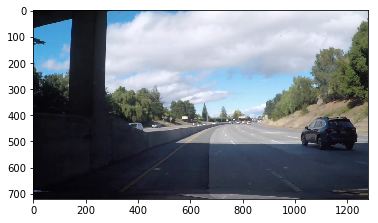

In [17]:
iter_frames = clip1.iter_frames()
count = 0
for frame in iter_frames:
    if count == 143:
        plt.imshow(frame)
    count += 1